## Дипломный проект:

<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<b></b> Исследование оттока клиентов у оператора связи
</div>

<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).
    За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.
</div>

<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<b>Цель проекта:</b> Выявить клиентов, которые собираются уходить, и попробовать удержать их

<b>Задачи проекта:</b> 
- загрузить и осмотреть данные;
- подготовить данные;
- построить несколько моделей;
- выбрать модель с лучшей метрикой ROC-AUC;
- рассчитать на тестовой выборке метрики ROC-AUC и Accuracy
</div>

<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<b>ЭТАП 1:</b> EDA и план
</div>

In [1]:
#sudo pip3 install catboost --no-binary :all:

In [2]:
pip install phik

Note: you may need to restart the kernel to use updated packages.


In [3]:
#pip install lightgbm

In [4]:
!pip install scikit-learn==1.1.3

In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
#import lightgbm as lgb
#from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import make_column_transformer

from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
#from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression, Ridge

#from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import (
    OrdinalEncoder, 
    StandardScaler,
    OneHotEncoder
)

from sklearn.metrics import (
    confusion_matrix, 
    ConfusionMatrixDisplay,
    roc_auc_score,
    roc_curve,
    accuracy_score
)
import warnings
warnings.filterwarnings('ignore')

import time

from sklearn.model_selection import (
    cross_val_score, 
    GridSearchCV,
    train_test_split
)

from sklearn.pipeline import Pipeline
from nltk.probability import FreqDist

In [6]:
pd.set_option('display.max_columns', None)

<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
Загрузим информацию о договоре
</div>

In [7]:
try:
    contract = pd.read_csv('/Users/natalyyash/Downloads/contract_new.csv')
except:
    contract = pd.read_csv('/datasets/contract_new.csv')

In [8]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [9]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
На первый взгляд - пропусков нет, TotalCharges мог бы тоже быть float, а BeginDate - datetime
</div>

<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
Теперь посмотрим на таблицу с персональными данными клиента
</div>

In [10]:
try:
    personal = pd.read_csv('/Users/natalyyash/Downloads/personal_new.csv')
except:
    personal = pd.read_csv('/datasets/personal_new.csv')

In [11]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [12]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
Теперь посмотрим на таблицу с информацией об интернет-услугах
</div>

In [13]:
try:
    internet = pd.read_csv('/Users/natalyyash/Downloads/internet_new.csv')
except:
    internet = pd.read_csv('/datasets/internet_new.csv')

In [14]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [15]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
В этой таблице пропусков нет, но количество строк отличается от трех других таблиц, видимо, интернетом пользуются не все клиенты.
</div>

<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
Информация об услугах телефонии
</div>

In [16]:
try:
    phone = pd.read_csv('/Users/natalyyash/Downloads/phone_new.csv')
except:
    phone = pd.read_csv('/datasets/phone_new.csv')

In [17]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [18]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
Здесь также не все клиенты, и в столбце хочется тип данных bool
</div>

<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
Далее буду выполнять следующие шаги:
    
1. Изменить некоторые типы данных в таблицах
2. Объединить таблицы по customerID
3. Заполнить пропуски
4. Выделить целевой признак из столбца EndDate (ушел ли клиент или нет)
5. Выбрать модели, подходящие для данной задачи классификации
6. Исследовать модели, выбрать лучшую
7. Проверить лучшую модель на тестовой выборке

</div>

## Этап 2:

<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
Моделирование
</div>

<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
Дополненный план:
    
1. Изменить некоторые типы данных в таблицах
2. Объединить таблицы по customerID
3. Заполнить пропуски
4. Выделить целевой признак из столбца EndDate (ушел ли клиент или нет)
5. Выбрать модели, подходящие для данной задачи классификации
6. Исследовать модели, выбрать лучшую
7. Анализ важности признаков
8. Матрица ошибок
9. Проверить лучшую модель на тестовой выборке
</div>

<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
1. Посмотрим на значения в столбцах, изменим некоторые типы данных в таблицах

</div>

In [19]:
contract

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,2035.2
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7430.4
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,325.6
7041,8361-LTMKD,2019-07-01,No,Month-to-month,Yes,Mailed check,74.40,520.8


<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
Посмотрим, сколько уникальных значений в категориальных столбцах

</div>

In [20]:
contract['PaperlessBilling'].value_counts()

Yes    4171
No     2872
Name: PaperlessBilling, dtype: int64

In [21]:
contract['Type'].value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64

In [22]:
contract['PaymentMethod'].value_counts()

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64

<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
Значений немного, можно будет обойтись кодированием OHE для всех моделей

</div>

In [23]:
#contract['TotalCharges'] = contract['TotalCharges'].astype('float')

<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
Код выше выдаёт ошибку, проверим, что не так

</div>

In [24]:
contract['TotalCharges'].isna().sum()

0

<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
Пропусков как будто нет
</div>

In [25]:
contract[pd.to_numeric(contract['TotalCharges'], errors='coerce').isnull()]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
Здесь не пропуски, а пробелы. Это новые клиенты, так как в условиях задачи сказано, что информация о договорах актуальна на 1 февраля 2020. Думаю, допустимо заменить пробелы в столбце TotalCharges на значения из столбца MonthlyCharges
</div>

In [26]:
contract.loc[pd.to_numeric(contract['TotalCharges'], errors='coerce').isnull(), 'TotalCharges'] = contract['MonthlyCharges']
contract[pd.to_numeric(contract['TotalCharges'], errors='coerce').isnull()]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges


In [27]:
contract.loc[[488, 753,936]]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,52.55
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,20.25
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,80.85


<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
Заменили. Теперь переведем значения в тип float
</div>

In [28]:
contract['TotalCharges'] = contract['TotalCharges'].astype('float')
contract['TotalCharges']

0         31.04
1       2071.84
2        226.17
3       1960.60
4        353.50
         ...   
7038    2035.20
7039    7430.40
7040     325.60
7041     520.80
7042    7251.82
Name: TotalCharges, Length: 7043, dtype: float64

<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
Теперь переведем BeginDate в формат datetime
</div>

In [29]:
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'], format = '%Y.%m.%dT%H:%M:%S', infer_datetime_format=True)
contract['BeginDate'].head()

0   2020-01-01
1   2017-04-01
2   2019-10-01
3   2016-05-01
4   2019-09-01
Name: BeginDate, dtype: datetime64[ns]

<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
Сначала выделим целевой признак из столбца EndDate. Там есть значения No - клиент не ушел(0), где дата - ушел(1)
</div>

In [30]:
contract.loc[contract['EndDate'] == 'No','target'] = 0
contract.loc[contract['EndDate'] != 'No','target'] = 1

In [31]:
contract.head(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,0.0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,0.0
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,0.0
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,0.0
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,0.0
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96,0.0
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,0.0
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48,0.0
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68,0.0
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35,1.0


<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
Посмотрим, сколько строк со значением No
</div>

In [32]:
contract.loc[contract['EndDate']=='No'].head(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,0.0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,0.0
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,0.0
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,0.0
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,0.0
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96,0.0
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,0.0
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48,0.0
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68,0.0
10,9763-GRSKD,2019-01-01,No,Month-to-month,Yes,Mailed check,49.95,649.35,0.0


<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
Допустимо заменить их на конечную дату - 2020-02-01
</div>

In [33]:
contract.loc[contract['EndDate']=='No', 'EndDate'] = '2020-02-01'

In [34]:
contract.loc[contract['EndDate']=='No'].head(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target


In [35]:
contract.head(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0.0
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0.0
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0.0
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,0.0
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,0.0
5,9305-CDSKC,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,99.65,1150.96,0.0
6,1452-KIOVK,2018-04-01,2020-02-01,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,0.0
7,6713-OKOMC,2019-04-01,2020-02-01,Month-to-month,No,Mailed check,29.75,300.48,0.0
8,7892-POOKP,2017-07-01,2020-02-01,Month-to-month,Yes,Electronic check,104.80,3573.68,0.0
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35,1.0


<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
Теперь переведем EndDate в формат datetime

</div>

In [36]:
contract['EndDate'] = pd.to_datetime(contract['EndDate'] , format = '%Y.%m.%dT%H:%M:%S', infer_datetime_format=True)
contract['EndDate'] #.head()

0      2020-02-01
1      2020-02-01
2      2020-02-01
3      2020-02-01
4      2020-02-01
          ...    
7038   2020-02-01
7039   2020-02-01
7040   2020-02-01
7041   2020-02-01
7042   2020-02-01
Name: EndDate, Length: 7043, dtype: datetime64[ns]

<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
Теперь тип - datetime
</div>

In [37]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0.0
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0.0
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0.0
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,0.0
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,0.0


In [38]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   target            7043 non-null   float64       
dtypes: datetime64[ns](2), float64(3), object(4)
memory usage: 495.3+ KB


<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
Типы данных нас устраивают
</div>

<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
Теперь следующая таблица, посмотрим на данные
</div>

In [39]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [40]:
personal['gender'].value_counts()

Male      3555
Female    3488
Name: gender, dtype: int64

In [41]:
personal['SeniorCitizen'] = personal['SeniorCitizen'] == 1
personal['SeniorCitizen'].value_counts()

False    5901
True     1142
Name: SeniorCitizen, dtype: int64

In [42]:
personal['Partner'].value_counts()

No     3641
Yes    3402
Name: Partner, dtype: int64

In [43]:
personal['Dependents'].value_counts()

No     4933
Yes    2110
Name: Dependents, dtype: int64

<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
Типы данных нас устраивают, все столбцы бинарные
</div>

<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
Теперь следующие две таблицы
</div>

In [44]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [45]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
Всё в порядке, менять ничего не будем
</div>

<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
2. Объединяем таблицы по столбцу customerID
</div>

In [46]:
con_per = contract.merge(personal, on='customerID', how='outer') 
con_per_int = con_per.merge(internet, on='customerID', how='outer')
df = con_per_int.merge(phone, on='customerID', how='outer')
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0.0,Female,False,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0.0,Male,False,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0.0,Male,False,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,0.0,Male,False,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,0.0,Female,False,No,No,Fiber optic,No,No,No,No,No,No,No


<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
Появились пропуски
    <br>
3. Заполняем пропуски
</div>

In [47]:
df.isna().sum()

customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
target                 0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64

<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
Пропуски только в тех столбцах, где клиенты пользуются только одной услугой - интеренетом или телефонией
    <br>
Заполним их No
</div>

In [48]:
col_int = ['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
col_tel = ['MultipleLines']

In [49]:
df[col_int].tail(6)

,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
7037,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7038,DSL,Yes,No,Yes,Yes,Yes,Yes
7039,Fiber optic,No,Yes,Yes,No,Yes,Yes
7040,DSL,Yes,No,No,No,No,No
7041,Fiber optic,No,No,No,No,No,No
7042,Fiber optic,Yes,No,Yes,Yes,Yes,Yes


In [50]:
df[col_int] = df[col_int].fillna('No')
df[col_int].tail(6)

,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
7037,No,No,No,No,No,No,No
7038,DSL,Yes,No,Yes,Yes,Yes,Yes
7039,Fiber optic,No,Yes,Yes,No,Yes,Yes
7040,DSL,Yes,No,No,No,No,No
7041,Fiber optic,No,No,No,No,No,No
7042,Fiber optic,Yes,No,Yes,Yes,Yes,Yes


In [51]:
df[col_tel].head(6)

,MultipleLines
0,NaN
1,No
2,No
3,NaN
4,No
5,Yes


In [52]:
df[col_tel] = df[col_tel].fillna('No')
df[col_tel].head(6)

,MultipleLines
0,No
1,No
2,No
3,No
4,No
5,Yes


In [53]:
df.isna().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
target              0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
dtype: int64

<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
    Пропуски заполнены
</div>

<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
Создадим признак days - сколько дней человек является клиентом компании
</div>

In [54]:
df[['BeginDate','EndDate']].head(10)

,BeginDate,EndDate
0,2020-01-01,2020-02-01
1,2017-04-01,2020-02-01
2,2019-10-01,2020-02-01
3,2016-05-01,2020-02-01
4,2019-09-01,2020-02-01
5,2019-03-01,2020-02-01
6,2018-04-01,2020-02-01
7,2019-04-01,2020-02-01
8,2017-07-01,2020-02-01
9,2014-12-01,2017-05-01


In [55]:
df['days'] = df['EndDate'] - df['BeginDate']
df['days'].head(10)

0     31 days
1   1036 days
2    123 days
3   1371 days
4    153 days
5    337 days
6    671 days
7    306 days
8    945 days
9    882 days
Name: days, dtype: timedelta64[ns]

<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
Переведём days в тип int
</div>

In [56]:
df['days'].describe()

count                           7043
mean     898 days 13:20:14.993610672
std      683 days 03:07:56.034286544
min                  0 days 00:00:00
25%                276 days 00:00:00
50%                761 days 00:00:00
75%               1461 days 00:00:00
max               2314 days 00:00:00
Name: days, dtype: object

In [57]:
df['days'] = df['days'].dt.days
df['days'].head(10)

0      31
1    1036
2     123
3    1371
4     153
5     337
6     671
7     306
8     945
9     882
Name: days, dtype: int64

<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
Перед матрицей корреляции удалим столбцы customerID и даты
</div>

In [58]:
df = df.drop(['customerID', 'BeginDate', 'EndDate'], axis=1)
df.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,days
0,Month-to-month,Yes,Electronic check,29.85,31.04,0.0,Female,False,Yes,No,DSL,No,Yes,No,No,No,No,No,31
1,One year,No,Mailed check,56.95,2071.84,0.0,Male,False,No,No,DSL,Yes,No,Yes,No,No,No,No,1036
2,Month-to-month,Yes,Mailed check,53.85,226.17,0.0,Male,False,No,No,DSL,Yes,Yes,No,No,No,No,No,123
3,One year,No,Bank transfer (automatic),42.30,1960.60,0.0,Male,False,No,No,DSL,Yes,No,Yes,Yes,No,No,No,1371
4,Month-to-month,Yes,Electronic check,70.70,353.50,0.0,Female,False,No,No,Fiber optic,No,No,No,No,No,No,No,153


<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
Посмотрим на матрицу корреляции
</div>

In [59]:
df.phik_matrix(interval_cols=['MonthlyCharges', 'TotalCharges', 'days'])

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,days
Type,1.000000,0.106860,0.277462,0.388444,0.468471,0.094015,0.000000,0.086231,0.179736,0.147680,0.505187,0.152145,0.098884,0.137610,0.179999,0.066961,0.069608,0.065498,0.634155
PaperlessBilling,0.106860,1.000000,0.370495,0.467812,0.203144,0.083398,0.000000,0.242133,0.013218,0.172593,0.231438,0.000000,0.196443,0.160796,0.055929,0.343524,0.325551,0.252972,0.026799
PaymentMethod,0.277462,0.370495,1.000000,0.399526,0.335175,0.214832,0.000000,0.292725,0.243008,0.224903,0.323886,0.262911,0.282475,0.306866,0.272101,0.377209,0.378907,0.339313,0.350964
MonthlyCharges,0.388444,0.467812,0.399526,1.000000,0.711029,0.226280,0.008175,0.304985,0.203545,0.184366,0.919002,0.551621,0.629541,0.667481,0.576525,0.835340,0.833307,0.675883,0.387727
TotalCharges,0.468471,0.203144,0.335175,0.711029,1.000000,0.304287,0.000000,0.137707,0.381042,0.082134,0.489674,0.521522,0.622643,0.641455,0.549866,0.642144,0.644671,0.572584,0.847414
target,0.094015,0.083398,0.214832,0.226280,0.304287,1.000000,0.008581,0.086159,0.226688,0.046871,0.056621,0.132594,0.229482,0.218380,0.103652,0.200198,0.222232,0.261237,0.374569
gender,0.000000,0.000000,0.000000,0.008175,0.000000,0.008581,1.000000,0.000000,0.000000,0.000000,0.000000,0.018397,0.009882,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SeniorCitizen,0.086231,0.242133,0.292725,0.304985,0.137707,0.086159,0.000000,1.000000,0.016992,0.324576,0.160702,0.057028,0.102065,0.090686,0.092565,0.163120,0.186141,0.221313,0.063315
Partner,0.179736,0.013218,0.243008,0.203545,0.381042,0.226688,0.000000,0.016992,1.000000,0.652122,0.000000,0.221673,0.219223,0.238079,0.185993,0.193258,0.182011,0.220101,0.453688
Dependents,0.147680,0.172593,0.224903,0.184366,0.082134,0.046871,0.000000,0.324576,0.652122,1.000000,0.108463,0.124945,0.031533,0.010416,0.096912,0.017331,0.058999,0.033103,0.198729


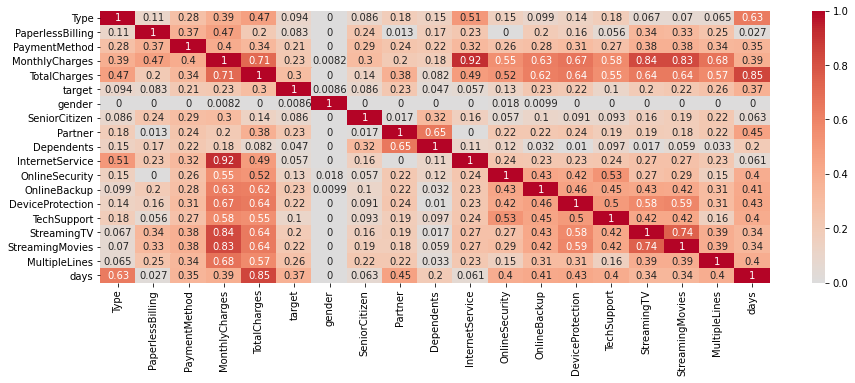

In [60]:
plt.figure(figsize = (15,5))
sns.heatmap(df.phik_matrix(interval_cols=['MonthlyCharges', 'TotalCharges', 'days']), cmap='coolwarm', center=0, annot=True)
plt.show()

<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
"мультиколлинеарность можно отслеживать по коэффициенту корреляции между предикторами >=0.8, и из такой пары скоррелированных признаков один нужно удалить. При выборке признака для удаления можно стандартно ориентироваться на коэффициенты корреляции каждого из пары скоррелированных предикторов с целевым признаком и удалить тот, у которого связь с целевым признаком ниже"
    <br>
На тепловой карте видно, что есть признаки с очень сильной корреляцией. 
    <br>
    1. InternetService коррелирует с MonthlyCharges со значением 0.92. Удалим MonthlyCharges, так как его корреляция с target выше, чем у InternetService (0.23 против 0.057)
    <br>
    2. Также высокая корреляция у streaming tv и streaming movies опять же с MonthlyCharges, и в этом случае так же выберем MonthlyCharges как признак с более высокой корреляцией с target
    <br>
    3. Также столбец days коррелирует с TotalCharges, причем days сильнее корелирует с target, чем TotalCharges (0.37 против 0.3). Но хочется оставить days
    <br>
Итого удаляем только MonthlyCharges и TotalCharges
</div>

<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
Теперь подготовим таблицу к моделированию
</div>

<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
Удалим столбцы MonthlyCharges и TotalCharges
</div>

In [61]:
data = df.drop(['MonthlyCharges', 'TotalCharges'], axis=1)
data.head()

,Type,PaperlessBilling,PaymentMethod,target,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,days
0,Month-to-month,Yes,Electronic check,0.0,Female,False,Yes,No,DSL,No,Yes,No,No,No,No,No,31
1,One year,No,Mailed check,0.0,Male,False,No,No,DSL,Yes,No,Yes,No,No,No,No,1036
2,Month-to-month,Yes,Mailed check,0.0,Male,False,No,No,DSL,Yes,Yes,No,No,No,No,No,123
3,One year,No,Bank transfer (automatic),0.0,Male,False,No,No,DSL,Yes,No,Yes,Yes,No,No,No,1371
4,Month-to-month,Yes,Electronic check,0.0,Female,False,No,No,Fiber optic,No,No,No,No,No,No,No,153


<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
Посмотрим на распределение признаков
</div>

In [62]:
df['MonthlyCharges'].describe()

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: MonthlyCharges, dtype: float64

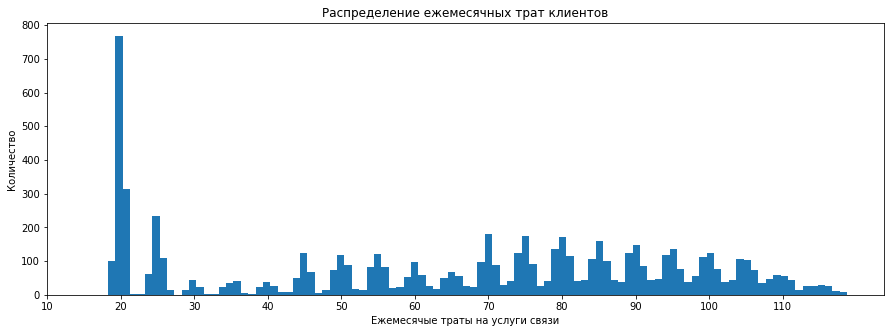

In [63]:
plt.figure(figsize=(15,5))
plt.hist(df['MonthlyCharges'], bins=100)
plt.xticks(range(10, 120, 10))
plt.title('Распределение ежемесячных трат клиентов')
plt.xlabel('Ежемесячые траты на услуги связи') 
plt.ylabel('Количество') 
plt.show()

<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
В среднем клиенты тратят на связь 65 доллара в месяц, пик находится примерно на 20 долларах - это самая распространенная сумма платежа за связь
</div>

In [64]:
data['days'].describe()

count    7043.000000
mean      898.555729
std       683.130510
min         0.000000
25%       276.000000
50%       761.000000
75%      1461.000000
max      2314.000000
Name: days, dtype: float64

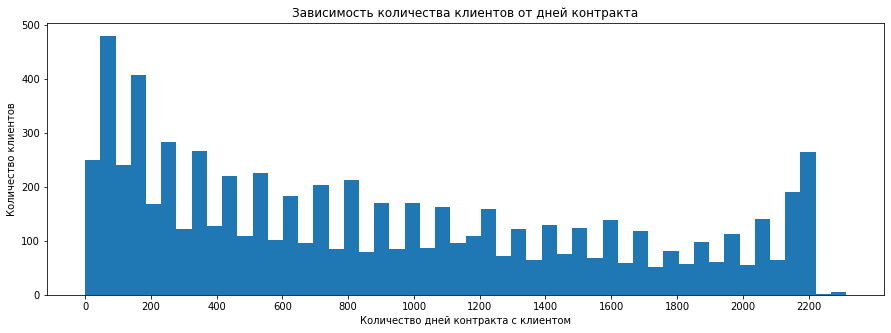

In [65]:
plt.figure(figsize=(15,5))
plt.hist(data['days'], bins=50)
plt.xticks(range(0, 2400, 200))
plt.title('Зависимость количества клиентов от дней контракта')
plt.xlabel('Количество дней контракта с клиентом') 
plt.ylabel('Количество клиентов') 
plt.show()

<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
Большое количество клиентов - новые, но есть и те, которые в компании по 5-6 лет
</div>

<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
Теперь посмотрим на кактегориальные столбцы
</div>

In [66]:
col_cat = ['Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'SeniorCitizen', 'Partner', 
           'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingMovies', 'MultipleLines', 'target']

In [67]:
col_cat1 = ['Type', 'PaymentMethod','InternetService']
col_cat2 = ['PaperlessBilling', 'gender', 'SeniorCitizen', 'Partner', 
          'Dependents', 'OnlineSecurity']
col_cat3 = ['OnlineBackup', 
           'DeviceProtection', 'TechSupport', 'StreamingMovies', 'MultipleLines', 'target']

In [68]:
col_num = ['MonthlyCharges', 'days']

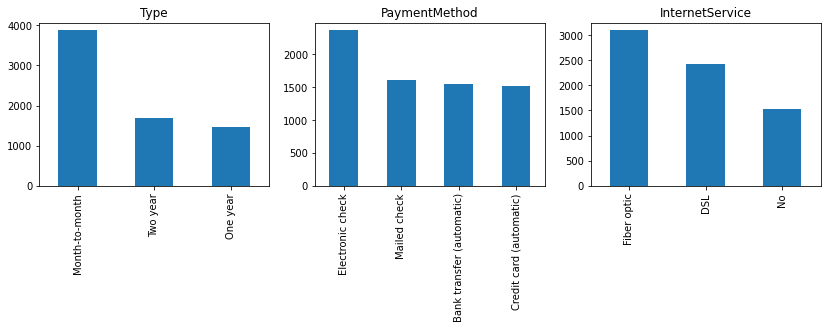

In [69]:
#fig, axs = plt.subplots(1,len(data.columns)-1,figsize=(14,5))

fig, axs = plt.subplots(1,3,figsize=(14,3))
for i,x in enumerate(data[col_cat1]):
    data[x].value_counts().plot(kind='bar',ax=axs[i], title=x)

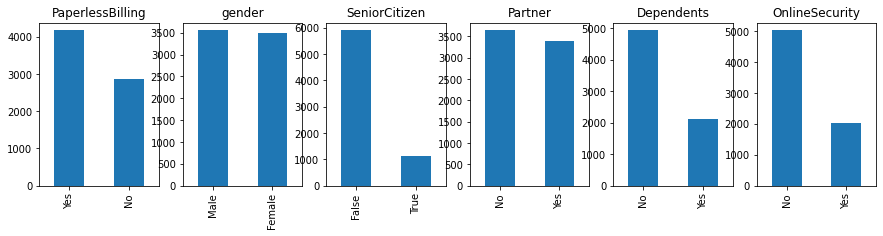

In [70]:
fig, axs = plt.subplots(1,6,figsize=(15,3))
for i,x in enumerate(data[col_cat2]):
    data[x].value_counts().plot(kind='bar',ax=axs[i], title=x)

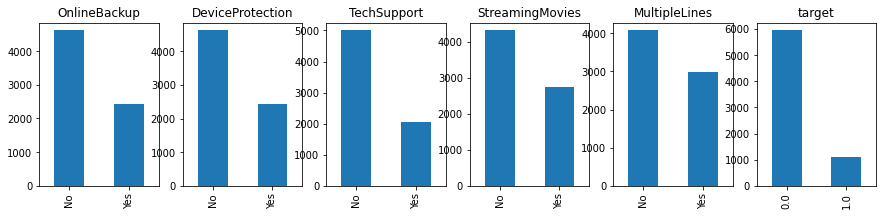

In [71]:
fig, axs = plt.subplots(1,6,figsize=(15,3))
for i,x in enumerate(data[col_cat3]):
    data[x].value_counts().plot(kind='bar',ax=axs[i], title=x)

<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
Все бинарные столбцы выглядят обычно, разве что клиенты по большей части предпочитают платить каждый месяц, электронный чеком, преобладают люди непенсионного возраста
</div>

<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
Сделаем разбиение на тренировочную и тестовую выборки в соотношении 3:1
</div>

In [72]:
data.head()

,Type,PaperlessBilling,PaymentMethod,target,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,days
0,Month-to-month,Yes,Electronic check,0.0,Female,False,Yes,No,DSL,No,Yes,No,No,No,No,No,31
1,One year,No,Mailed check,0.0,Male,False,No,No,DSL,Yes,No,Yes,No,No,No,No,1036
2,Month-to-month,Yes,Mailed check,0.0,Male,False,No,No,DSL,Yes,Yes,No,No,No,No,No,123
3,One year,No,Bank transfer (automatic),0.0,Male,False,No,No,DSL,Yes,No,Yes,Yes,No,No,No,1371
4,Month-to-month,Yes,Electronic check,0.0,Female,False,No,No,Fiber optic,No,No,No,No,No,No,No,153


In [73]:
features = data.drop(['target'], axis=1)
target = data['target']

In [74]:
features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                    test_size=0.25, 
                                                    random_state=190623,
                                                    stratify=target)

In [75]:
print (features_train.shape)
print (target_test.shape)

(5282, 16)
(1761,)


<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
Затем закодируем ohe, а также ordinal
    <br>
    Без кодирования будем использовать для catboost, ohe - для логистической регрессии, ordinal encoder - для случайного леса
</div>

In [76]:
col_cat4 = ['Type',
 'PaperlessBilling',
 'PaymentMethod',
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'MultipleLines']
col_num = ['days']

In [77]:
features_train_ohe = features_train.copy()
features_test_ohe = features_test.copy()

In [78]:
ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

In [79]:
ohe.fit(features_train[col_cat4])

OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

In [80]:
features_train_ohe[ohe.get_feature_names_out()] = ohe.transform(features_train_ohe[col_cat4])

In [81]:
features_train_ohe = features_train_ohe.drop(col_cat4, axis=1)

In [82]:
scaler = StandardScaler()

features_train_ohe[col_num] = scaler.fit_transform(features_train_ohe[col_num])

features_train_ohe.head()

,days,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,gender_Male,SeniorCitizen_True,Partner_Yes,Dependents_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes
4169,-0.597179,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0
5322,-0.153724,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
3001,-0.906430,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4812,-0.776603,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
4711,0.113223,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [83]:
features_train_ohe

,days,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,gender_Male,SeniorCitizen_True,Partner_Yes,Dependents_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes
4169,-0.597179,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0
5322,-0.153724,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
3001,-0.906430,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4812,-0.776603,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
4711,0.113223,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5503,0.247427,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3605,0.202206,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1204,-0.508196,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6968,-0.821823,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [84]:
print (features_train_ohe.shape)
print (target_train.shape)

(5282, 20)
(5282,)


<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
Теперь закодируем тестовую выборку
</div>

In [85]:
features_test_ohe[ohe.get_feature_names_out()] = ohe.transform(features_test_ohe[col_cat4])

features_test_ohe = features_test_ohe.drop(col_cat4, axis=1)

features_test_ohe[col_num] = scaler.transform(features_test_ohe[col_num])

features_test_ohe.head()

,days,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,gender_Male,SeniorCitizen_True,Partner_Yes,Dependents_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes
4130,-0.862668,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4849,0.466236,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
980,-0.419213,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3810,-1.263819,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.202206,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
Выполним также кодирование ordinal encoder для случайного леса
</div>

In [86]:
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value = -1)

In [87]:
features_train_ord = features_train.copy() 
features_test_ord = features_test.copy() 

In [88]:
enc.fit(features_train_ord[col_cat4])

OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

In [89]:
features_train_ord[col_cat4] = enc.transform(features_train_ord[col_cat4])

features_train_ord.head()

,Type,PaperlessBilling,PaymentMethod,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,days
4169,0.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,488
5322,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,792
3001,0.0,0.0,3.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,276
4812,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,365
4711,1.0,0.0,3.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,975


In [90]:
features_test_ord[col_cat4] = enc.transform(features_test_ord[col_cat4])

features_test_ord

,Type,PaperlessBilling,PaymentMethod,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,days
4130,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,306
4849,1.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1217
980,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,610
3810,0.0,0.0,2.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31
1,1.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5633,0.0,0.0,3.0,1.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,184
6179,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,457
5507,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,853
3535,2.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,639


In [91]:
print (features_train_ord.shape)
print (target_test.shape)

(5282, 16)
(1761,)


In [92]:
scaler = StandardScaler()
scaler.fit(features_train_ord[col_num])
features_train_ord[col_num] = scaler.transform(features_train_ord[col_num])
features_test_ord[col_num] = scaler.transform(features_test_ord[col_num])
features_train_ord.head()

,Type,PaperlessBilling,PaymentMethod,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,days
4169,0.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,-0.597179
5322,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,-0.153724
3001,0.0,0.0,3.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.906430
4812,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,-0.776603
4711,1.0,0.0,3.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.113223


In [93]:
features_test_ord.head()

,Type,PaperlessBilling,PaymentMethod,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,days
4130,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,-0.862668
4849,1.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.466236
980,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.419213
3810,0.0,0.0,2.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.263819
1,1.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.202206


<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
6. Исследуем модели, выберем лучшую
</div>


<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
Рассмотрим модель случайного леса
</div>

In [94]:
%%time

params_1 = {'model_1__n_estimators':[10,20, 40, 60, 80, 100],
        'model_1__max_depth':[None] + [i for i in range(2, 7)]}
pipeline_1 = Pipeline([
    ('model_1', RandomForestClassifier(random_state=190623))])
grid_1 = GridSearchCV(pipeline_1, cv=3, n_jobs=-1, param_grid=params_1, scoring='roc_auc')

CPU times: user 50 µs, sys: 7 µs, total: 57 µs
Wall time: 60.1 µs


<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
Подбираем параметры
</div>

In [95]:
grid_1.fit(features_train_ord, target_train)

roc_auc_forest = grid_1.best_score_
grid_1_best_params = grid_1.best_params_
print ('best_score', roc_auc_forest)
print ('Параметры', grid_1_best_params)

best_score 0.8195521623196652
Параметры {'model_1__max_depth': 6, 'model_1__n_estimators': 100}


<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
best_score 0.8195521623196652
    <br>

Параметры {'model_1__max_depth': 6, 'model_1__n_estimators': 100}
</div>

<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
Запомним категориальные признаки и рассмотрим бустинг CatBoost
</div>

In [96]:
cat_features = features.select_dtypes(['object']).columns 
cat_features = list(cat_features)
cat_features

['Type',
 'PaperlessBilling',
 'PaymentMethod',
 'gender',
 'Partner',
 'Dependents',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'MultipleLines']

In [97]:
model_2 = CatBoostClassifier(random_state=190623, cat_features=cat_features)
params_2 = {'model_2__learning_rate': [0.01, 0.1, 0.2, 0.3, 0.4],
        'model_2__max_depth': [2, 3, 5, 7],
        'model_2__iterations': [30, 40, 50, 70, 90]}
pipeline_2 = Pipeline([
    ('model_2', CatBoostClassifier(random_state=190623, cat_features=cat_features))])
grid_2 = GridSearchCV(pipeline_2, cv=3, n_jobs=-1, param_grid=params_2, scoring='roc_auc', verbose=2)

In [98]:
%%time
grid_2.fit(features_train, target_train)
roc_auc_catboost = grid_2.best_score_
grid_2_best_params = grid_2.best_params_
print ('best_score', roc_auc_catboost)
print ('Параметры', grid_2_best_params)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
0:	learn: 0.6882666	total: 48.4ms	remaining: 1.4s
1:	learn: 0.6835596	total: 49.4ms	remaining: 691ms
2:	learn: 0.6789264	total: 50.4ms	remaining: 454ms
3:	learn: 0.6743053	total: 51.4ms	remaining: 334ms
4:	learn: 0.6698518	total: 52.2ms	remaining: 261ms
5:	learn: 0.6655077	total: 53ms	remaining: 212ms
6:	learn: 0.6610879	total: 54ms	remaining: 177ms
7:	learn: 0.6568548	total: 54.8ms	remaining: 151ms
8:	learn: 0.6526318	total: 55.6ms	remaining: 130ms
9:	learn: 0.6484041	total: 56.4ms	remaining: 113ms
10:	learn: 0.6442544	total: 57.4ms	remaining: 99.2ms
11:	learn: 0.6403325	total: 58.2ms	remaining: 87.3ms
12:	learn: 0.6365069	total: 58.9ms	remaining: 77.1ms
13:	learn: 0.6325777	total: 59.7ms	remaining: 68.2ms
14:	learn: 0.6287033	total: 60.5ms	remaining: 60.5ms
15:	learn: 0.6249291	total: 61.3ms	remaining: 53.6ms
16:	learn: 0.6213226	total: 62ms	remaining: 47.4ms
17:	learn: 0.6177338	total: 62.8ms	remaining: 41.8ms
18:	learn:

<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
best_score 0.8525987773164406
    <br>
Параметры {'model_2__iterations': 90, 'model_2__learning_rate': 0.4, 'model_2__max_depth': 5}
    <br>
Wall time: 2min 44s
</div>

<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
Логистическая регрессия
</div>

In [99]:
%%time
model_3 = LogisticRegression(random_state=190623)
params_3 = {'model_3__C':[1, 3, 0.5],
           'model_3__penalty':['l1','l2'],
           'model_3__solver':['liblinear', 'lbfgs']} 
pipeline_3 = Pipeline([
    ('model_3', LogisticRegression(random_state=190623,))])
grid_3 = GridSearchCV(pipeline_3, cv=3, n_jobs=-1, param_grid=params_3, scoring='roc_auc')

CPU times: user 50 µs, sys: 4 µs, total: 54 µs
Wall time: 57.2 µs


In [100]:
%%time
grid_3.fit(features_train_ohe, target_train)

roc_auc_logistic = grid_3.best_score_
grid_3_best_params = grid_3.best_params_
print ('best_score', roc_auc_logistic)
print ('Параметры', grid_3_best_params)

best_score 0.7496518909974396
Параметры {'model_3__C': 0.5, 'model_3__penalty': 'l2', 'model_3__solver': 'lbfgs'}
CPU times: user 2.62 s, sys: 3.12 s, total: 5.74 s
Wall time: 5.69 s


<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
best_score 0.7492082923543447
    <br>
Параметры {'model_3__C': 3, 'model_3__penalty': 'l1', 'model_3__solver': 'liblinear'}

</div>

<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
Посмотрим на метрики
</div>

In [101]:
scores = [roc_auc_forest, roc_auc_catboost, roc_auc_logistic]
models = ['RandomForest', 'CatBoost', 'LogicticRegression']

In [102]:
pd.DataFrame(data=scores, index=models, columns=['roc_auc']).sort_values(by='roc_auc', ascending=True)

,roc_auc
LogicticRegression,0.749652
RandomForest,0.819552
CatBoost,0.852599


<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
Лучший результат на валидационной выборке показал CatBoost
</div>

<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
Посчитаем метрику на тестовой выборке на модели CatBoost
</div>

In [114]:
probabilities = grid_2.predict_proba(features_test)
probabilities_one = probabilities[:, 1]
roc_auc_catboost_test = roc_auc_score(target_test, probabilities_one) 

print('ROC-AUC модели catboost на тестовой выборке:', roc_auc_catboost_test)

ROC-AUC модели catboost на тестовой выборке: 0.8723675516946042


<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
CatBoost показал метрику выше 0.85(условие техзадания), но меньше 0.95 (что свидетельствовало бы о переобучении)
    <br>
    <br>
Посмотрим на матрицу ошибок
</div>

In [104]:
predicted = grid_2.predict(features_test)

In [117]:
cm = confusion_matrix(target_test,predicted)
cm

array([[1458,   28],
       [ 184,   91]])

<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
[1458,   28],
    <br>
[ 184,   91]
    <br>
    1458 - верно предсказанные положительные
    <br>
    91 - верно предсказанные отрицательные
    <br>
    28 - неверно предсказанные положительные
    <br>
    184 - неверно предсказанные отрицательные
    <br>
    <br>
Мало ложноположительных предсказаний. Значит, наша модель позволит вычислить тех, кто не собирается уходить, что сэкономит деньги компании, но может упустить некоторых клиентов, решивших уйти
</div>

<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
Выведем важность признаков
</div>

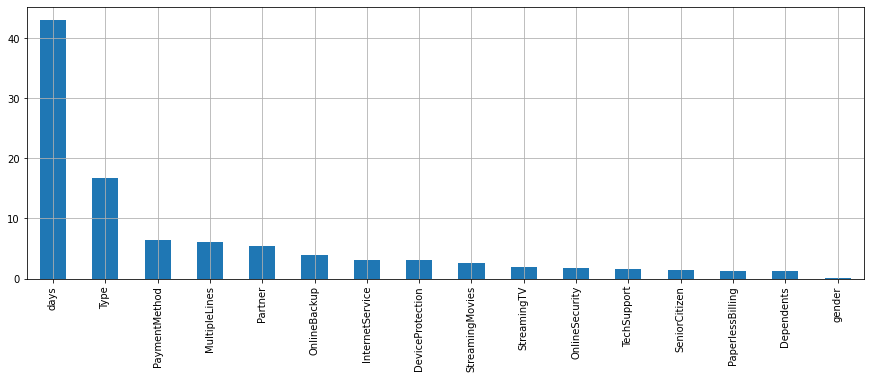

In [106]:
pd.DataFrame(data={'score': grid_2.best_estimator_.named_steps['model_2'].feature_importances_}, 
                      index=features.columns).sort_values(by='score', ascending=False).plot(kind='bar', grid=True,
                                               figsize=(15,5), legend=False)
plt.show()

<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
Более 40% важности признаков занимает сгенерированный признак days - срок контракта клиента с компанией. Далее с сильным отрывом идут Type, PaymentMethod, MultipleLines, Partner. А вот пол практически не имеет важности

<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
Посчитаем метрику accuracy
</div>

In [107]:
acc_catboost = accuracy_score(target_test, predicted)
print('accuracy модели catboost:', acc_catboost)

accuracy модели catboost: 0.8796138557637706


<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
accuracy модели catboost: 0.8796138557637706, это хороший результат
</div>

<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
Данная модель предсказывает уход клиентов с точностью 88%.
    <br>
    Она позволит вычислить тех, кто не собирается уходить, что сэкономит деньги компании, но может упустить некоторых клиентов, решивших уйти. Модель учитывает важность признаков, содержащихся в исходном датасете, такие как длительность контракта(разность конечной и начальной даты контракта), тип оплаты услуг(ежемесяный, за год или за два), способы оплаты услуг(автоматический, электронный чек или бумажный) и других
</div>

In [108]:
features_train.columns

Index(['Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'SeniorCitizen',
       'Partner', 'Dependents', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'MultipleLines', 'days'],
      dtype='object')

<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<b>Отчёт по решению:</b>
</div>

<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<b>Ключевые шаги работы над проектом:</b>
     <br>
    <br>      
1. Провели предобработку данных
    <br>
     <br>
2. Разделили датасет на тестовую и тренировочную выборки    
    <br>
     <br>
3. Выполнено ohe и ordinal кодирование, а также масштабирование признаков
    <br>
     <br>
4. Выбраны модели, подходящие для данной задачи классификации - RandomForest, CatBoost, LogisticRegression
    <br>
     <br>
5. Исследованы модели с гиперпараметрами, выбрана лучшая - CatBoost
    <br>
     <br>
6. Проверена лучшую модель (CatBoost) на тестовой выборке - метка auc-roc равна 0.87
    <br>
     <br>
7. Проанализивана важность признаков. Более 40% важности признаков занимает сгенерированный признак days - срок контракта клиента с компанией. Далее с сильным отрывом идут Type, PaymentMethod, MultipleLines, Partner. А вот пол практически не имеет важности
    <br>
     <br>
8. Проанализирована матрица ошибок. По ней видно, что в модель делает мало ложноположительных предсказаний. Значит, наша модель с большой точностью позволит вычислить тех, кто не собирается уходить, что сэкономит деньги компании, но может упустить некоторых клиентов, решивших уйти
    <br>
     <br>
9. Выведена метрика accuracy, она показывает, что данная модель предсказывает уход клиентов с точностью 88%.

</div>

<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<b>Анализ соответствия фактической работы запланированным шагам, рефлексия над сложностями и описание путей их решения:</b> 
    <br>
Фактическая работа соответствует запланированным шагам. 
    <br>
    Сложности возникли на кодировании ordinal encoder и достижении нужного значения метрики (>0.85), но были решены сбрасыванием индексов и подбором гиперпараметров
</div>

<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<b>4. Итоговый список признаков (с расшифровкой) для обучения модели, способы их обработки (как
кодировали/стандартизировали/преобразовывали).</b>
</div>

In [110]:
pd.DataFrame(np.array([['тип оплаты: ежемесячный, годовой и тд', 1, 1, 0], 
                       ['электронный платёжный документ', 1, 1, 0], 
                       ['способ оплаты', 1, 1, 0],
                       ['ушел клиент из компании или нет', 1, 1, 0],
                       ['пол', 1, 1, 0],
                       ['наличие пенсионного статуса по возрасту', 1, 1, 0],
                       ['наличие супруга(и)', 1, 1, 0],
                       ['наличие иждивенцев', 1, 1, 0],
                       ['тип подключения', 1, 1, 0],
                       ['блокировка небезопасных сайтов', 1, 1, 0],
                       ['облачное хранилище файлов для резервного копирования данных', 1, 1, 0],
                       ['антивирус', 1, 1, 0],
                       ['выделенная линия технической поддержки', 1, 1, 0],
                       ['стриминговое телевидение', 1, 1, 0],
                       ['каталог фильмов', 1, 1, 0],
                       ['наличие возможности ведения параллельных линий во время звонка', 1, 1, 0],
                       ['количество дней контракта клиента с компанией', 0, 0, 1]]), index=data.columns,
                   columns=['расшифровка признака', 'кодирование ohe', 'кодирование ordinal', 'масштабирование'])

,расшифровка признака,кодирование ohe,кодирование ordinal,масштабирование
Type,"тип оплаты: ежемесячный, годовой и тд",1,1,0
PaperlessBilling,электронный платёжный документ,1,1,0
PaymentMethod,способ оплаты,1,1,0
target,ушел клиент из компании или нет,1,1,0
gender,пол,1,1,0
SeniorCitizen,наличие пенсионного статуса по возрасту,1,1,0
Partner,наличие супруга(и),1,1,0
Dependents,наличие иждивенцев,1,1,0
InternetService,тип подключения,1,1,0
OnlineSecurity,блокировка небезопасных сайтов,1,1,0


<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<b>Краткое описание предобработки данных:</b> 
    <br>
1. Заменены пробелы в столбце TotalCharges значениями из столбца MonthlyCharges
    <br>
2. Изменены некоторые типы данных в таблицах (TotalCharges из object в float, BeginDate и EndDate из object в datetime)
    <br>
3. Выделен целевой признак(target) из столбца EndDate (ушел ли клиент(1) или нет(0)). 
    <br>
4. Объединены все четыре таблицы (contract, personal, internet, phone) в общую таблицу df по столбцу customerID
       <br>
5. Заполнены пропуски, появившиеся после объединения таблиц (у клиентов, не пользующихся какими-то услугами, проставили No в столбцах из таблиц internet и phone)
        <br>
6. Создан новый признак days - количество дней контракта с клиентом (разность между конечной и начальной датой контракта), изменили тип данных из timedelta на int
    <br>
7. Построена матрица корреляции, некоторые признаки коррелируют между собой с коэффициентом > 0.8
<br>
8. Удалены признаки MonthlyCharges и TotalCharges, чтобы избежать мультиколлинеарности
    <br>
9. Исследовано распределение признаков</div>

<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<b>Сводная таблица исследованных моделей и их метрика на кросс-валидации.</b></div>

In [111]:
pd.DataFrame(data=scores, index=models, columns=['roc_auc']).sort_values(by='roc_auc', ascending=True)

,roc_auc
LogicticRegression,0.749652
RandomForest,0.819552
CatBoost,0.852599


<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<b>Лучшая модель - название, гиперпараметры, метрика на кросс-валидации.</b> </div>

In [113]:
print ('Метрика ROC-AUC модели catboost на кросс-валидации', roc_auc_catboost)
print ('Гиперпараметры', grid_2_best_params)

Метрика roc-auc модели catboost на кросс-валидации 0.8525987773164406
Гиперпараметры {'model_2__iterations': 90, 'model_2__learning_rate': 0.4, 'model_2__max_depth': 5}


<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
Итоговая метрика на test (AUC-ROC и Accuracy).</div>

In [115]:
print('Метрика ROC-AUC модели catboost на тестовой выборке:', roc_auc_catboost_test)
print('accuracy модели catboost:', acc_catboost)

Метрика ROC-AUC модели catboost на тестовой выборке: 0.8723675516946042
accuracy модели catboost: 0.8796138557637706


<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
CatBoost показал метрику AUC-ROC выше 0.85(условие техзадания), но меньше 0.95 (что свидетельствовало бы о переобучении)
    <br>
    <br>
Метрика accuracy показывает, что данная модель предсказывает уход клиентов с точностью 88%.
<br>
Она позволит вычислить тех, кто не собирается уходить, что сэкономит деньги компании, но может упустить некоторых клиентов, решивших уйти. Модель учитывает важность признаков, содержащихся в исходном датасете, такие как длительность контракта(разность конечной и начальной даты контракта), тип оплаты услуг(ежемесяный, за год или за два), способы оплаты услуг(автоматический, электронный чек или бумажный) и других</div>

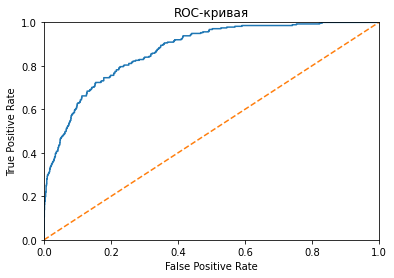

In [125]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one)

plt.figure()
plt.plot(fpr, tpr)

# ROC-кривая случайной модели 
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC-кривая')
plt.show()

<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
Наблюдается кривая намного лучше, чем кривая случайной модели (чем больше кривая ROC охватывает верхний левый угол графика, тем лучше модель классифицирует данные по категориям)
    <br>
Метрика AUC-ROC на модели catboost - это площадь под кривой, которая говорит нам, какая часть графика расположена под кривой.</div>

<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
Матрица ошибок (таблица или график + интерпретация). </div>

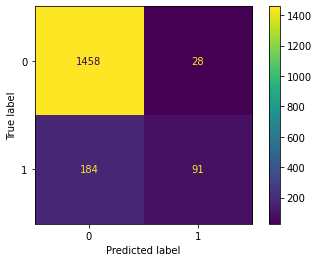

In [123]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm) 

disp.plot()
plt.show()

<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
1458 - верно предсказанные положительные
    <br>
    91 - верно предсказанные отрицательные
    <br>
    28 - неверно предсказанные положительные
    <br>
    184 - неверно предсказанные отрицательные
    <br>
    <br>
Мало ложноположительных предсказаний и много истинноположительных. Значит, наша модель позволит вычислить тех, кто не собирается уходить, что сэкономит деньги компании, но может упустить некоторых клиентов, решивших уйти
</div>

<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<b>Важность признаков (график + комментарии).</b> </div>

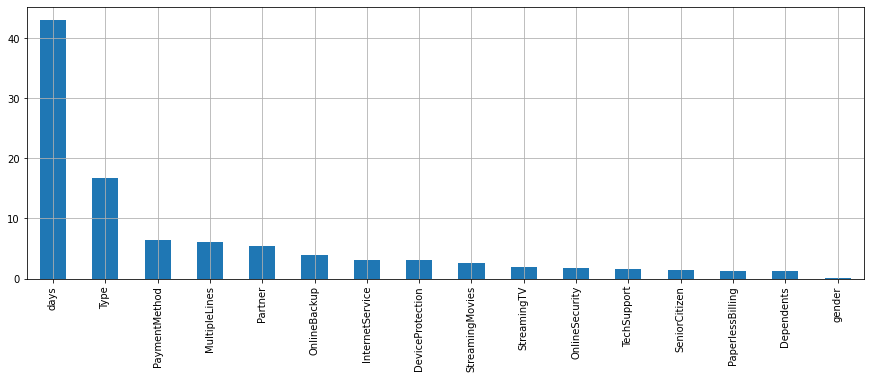

In [126]:
pd.DataFrame(data={'score': grid_2.best_estimator_.named_steps['model_2'].feature_importances_}, 
                      index=features.columns).sort_values(by='score', ascending=False).plot(kind='bar', grid=True,
                                               figsize=(15,5), legend=False)
plt.show()

<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
Более 40% важности признаков занимает сгенерированный признак days - срок контракта клиента с компанией. Далее с сильным отрывом идут Type, PaymentMethod, MultipleLines, Partner. А вот пол практически не имеет важности</div>